In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import model_to_dot, plot_model
from pprint import pprint
from sklearn.preprocessing import LabelEncoder 
import time
import pickle
from utils import *

2022-10-21 14:08:00.033209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data loading

In [2]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data('train.csv')


x shape   y shape
(8968, 6) (8968,)
(1500, 6) (1500,)
(1500, 6) (1500,)


/home/rodo/Documents/GitHub/showcase_AI_ML/1. Twitter Spam Detection/utils.py:27: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  full_data.iloc[:, 7] = pd.Categorical(full_data.iloc[:, 7])


In [3]:
print(x_train)

                                                  Tweet  following  followers  \
0                          It's nothing bitter about me        0.0        0.0   
1     Horse and dog die after eating poisoned cookie...    19478.0    30262.0   
2       Almost missed my stop falling asleep on the bus        0.0        0.0   
3     he's decent guy but yeah, has zero chill  with...        0.0        0.0   
4     Sanders stacks the commission with ringers lik...     2222.0     2534.0   
...                                                 ...        ...        ...   
8963  500 pound bomb dropped on U.S. Soldiers by mis...     2109.0     3488.0   
8964  First Tennessee Park to host Kings of Leon for...     8494.0    19039.0   
8965  Returning home is a mixed blessing for victims...     4732.0    14436.0   
8966  End House is under attack.\r\nNature has its f...    12800.0    46600.0   
8967  Consumer Reports finds best ellipticals, tread...     6534.0    19681.0   

      actions is_retweet   

In [4]:
# Only use the tweet column. Transformers are assumed to be good enough not to require it.
# (It's also going to take ages to complete.)
x_train = x_train.iloc[:,0]
x_val = x_val.iloc[:,0]
x_test = x_test.iloc[:,0]

In [5]:
x_train_tweet, x_val_tweet, x_test_tweet, \
x_train_las, x_val_las, x_test_las, \
max_length, tokenizer = tokenise(x_train, x_val, x_test)

In [6]:
# Turn Y into categorical (binary)
y_train_int, y_val_int, y_test_int = \
    transform_to_float(y_train.copy(), y_val.copy(), y_test.copy())

2022-10-21 14:08:02.390931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
type = ["Quality","Spam"]

In [8]:
# our transformer block
class TransformerBlock(layers.Layer):
    # Initialise the block. This will create all the layers that are used within the transformer block
    # params are:
    # - embed_dim: embedding dimension of the multi-head attention block
    # - num_heads: number of attention heads
    # - ff_dim: output size of the feed forward netowrk
    # - rate: dropout rate (default 0.1)
    #
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # multi-head attention, used to map input to internal representation
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # feed forward network, used to map transformer output to block output
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        # layer normalisation blocks, used after attention and feed foward layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        # dropout blocks, used after attention and feed foward layer
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Do a forward pass through the block
    # params are:
    # - inputs: what to pass through the network
    # - training: flag to indicate if we are training the model. Use to determine if dropout is on or off
    def call(self, inputs, training):
        # pass data through the multi-head attention
        attn_output = self.att(inputs, inputs)
        # dropout applied to attention output
        attn_output = self.dropout1(attn_output, training=training)
        # add attention output to the input and perform normalisation
        out1 = self.layernorm1(inputs + attn_output)
        # pass representation through feed forward network
        ffn_output = self.ffn(out1)
        # apply second dropout
        ffn_output = self.dropout2(ffn_output, training=training)
        # add intermediate representation to the final output, normalise, and return
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
        })
        return config

In [9]:
# our embedding generator
class TokenAndPositionEmbedding(layers.Layer):
    # create the embedding generator
    # params are:
    # - maxlen: maximum length of a sequence
    # - vocab_size: number of words in the vocabulary
    # - embed_dim: size of the embeddings to create
    # Note that both embedding layers will create the same size embeddings so they can be added
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        # create the word token embedding layer
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # create the position embedding layer
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    # call function, do a forward pass through the layer
    # params are:
    # - x: data to get embedding for
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        # get positions of the words in the sequence
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # get the position embeddings
        positions = self.pos_emb(positions)
        # get the token/word embeddings
        x = self.token_emb(x)
        # return the sum of the two embeddings
        return x + positions    
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'maxlen': self.maxlen,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,})
        return config

In [10]:
max_words=30000
embed_dim = 256  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

# create the input
inputs = layers.Input(shape=(max_length,))
# get our embeddings, note that we're using the embedding layer from above
embedding_layer = TokenAndPositionEmbedding(max_length, max_words, embed_dim)
x = embedding_layer(inputs)
# create a transformer layer and pass the embeddings through that.
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
# now we just want co classify the output of our transformer into positive or negative sentiment
# we can use a couple of dense layers to step down from our transformer output to our final classification
# decision
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(20, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
plot_model(model, show_shapes=True, to_file="xform.png")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 106)]             0         
                                                                 
 token_and_position_embeddin  (None, 106, 256)         7707136   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 106, 256)         2121248   
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 20)                5140  

In [11]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train_tweet, y_train_int, batch_size=128, epochs=5, validation_data=(x_val_tweet, y_val_int)
)

Epoch 1/5
 7/71 [=>............................] - ETA: 1:25 - loss: 0.9551 - accuracy: 0.5212

47/47 - 6s - loss: 0.2334 - accuracy: 0.9593 - 6s/epoch - 118ms/step
Testing loss: 0.23337014019489288
Testing accuracy: 0.9593333601951599
47/47 [==============================] - 6s 119ms/step
Prediction time is 5.6304473876953125 seconds
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       745
         1.0       0.98      0.94      0.96       755

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



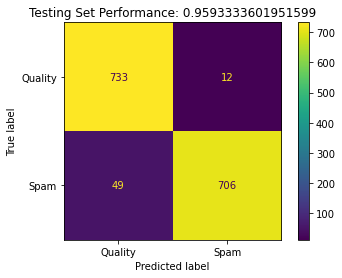

In [ ]:
test_scores = model.evaluate(x_test_tweet,y_test_int, verbose=2)
print('Testing loss:', test_scores[0])
print('Testing accuracy:', test_scores[1])
start_time = time.time()
predictions = model.predict(x_test_tweet)
print("Prediction time is %s seconds" % (time.time() - start_time))
pred = predictions >= 0.5
print(classification_report(y_test_int, pred))
cm = confusion_matrix(y_test_int, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=type)
disp.plot()
plt.title('Testing Set Performance: ' + str(test_scores[1]));
plt.show()
savedata(pred, "transformer_preds_random")

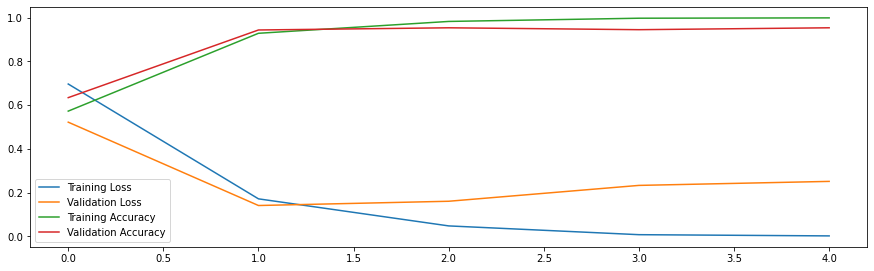

In [ ]:
fig = plt.figure(figsize=[15, 15])
ax = fig.add_subplot(3, 1, 1)
ax.plot(history.history['loss'], label = 'Training Loss')
ax.plot(history.history['val_loss'], label = 'Validation Loss')
ax.plot(history.history['accuracy'], label = 'Training Accuracy')
ax.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
ax.legend()

47/47 - 6s - loss: 0.2518 - accuracy: 0.9540 - 6s/epoch - 120ms/step
Validation loss: 0.25175905227661133
Validation accuracy: 0.9539999961853027
47/47 [==============================] - 6s 120ms/step
Prediction time is 5.685049772262573 seconds
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       759
         1.0       0.97      0.94      0.95       741

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



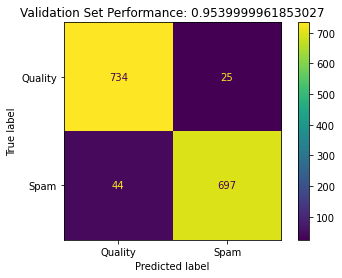

In [ ]:
val_scores = model.evaluate(x_val_tweet,y_val_int, verbose=2)
print('Validation loss:', val_scores[0])
print('Validation accuracy:', val_scores[1])
start_time = time.time()
predictions = model.predict(x_val_tweet)
print("Prediction time is %s seconds" % (time.time() - start_time))
pred = predictions >= 0.5
print(classification_report(y_val_int, pred))
cm = confusion_matrix(y_val_int, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=type)
disp.plot()
plt.title('Validation Set Performance: ' + str(val_scores[1]));
plt.show()

281/281 - 35s - loss: 2.8841e-04 - accuracy: 1.0000 - 35s/epoch - 126ms/step
Training loss: 0.0002884123823605478
Training accuracy: 1.0
281/281 [==============================] - 36s 127ms/step
Prediction time is 35.681246519088745 seconds
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4649
         1.0       1.00      1.00      1.00      4319

    accuracy                           1.00      8968
   macro avg       1.00      1.00      1.00      8968
weighted avg       1.00      1.00      1.00      8968



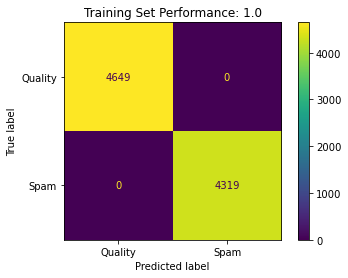

In [ ]:
train_scores = model.evaluate(x_train_tweet,y_train_int, verbose=2)
print('Training loss:', train_scores[0])
print('Training accuracy:', train_scores[1])
start_time = time.time()
predictions = model.predict(x_train_tweet)
print("Prediction time is %s seconds" % (time.time() - start_time))
pred = predictions >= 0.5
print(classification_report(y_train_int, pred))
cm = confusion_matrix(y_train_int, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=type)
disp.plot()
plt.title('Training Set Performance: ' + str(train_scores[1]));
plt.show()

In [ ]:
h = loaddata('transformer_preds_random')

In [ ]:
counter = 0
false_negatives = []
false_positives = []
correct = []
predictions = h
pred = [1 if prediction >= 0.5 else 0 for prediction in predictions]
for input, prediction, label in zip(range(x_test_tweet.shape[0]), pred , y_test_int):
    if prediction != label:
        print(input, 'has been classified as ', prediction, 'and should be ', label) 
        counter += 1
        if prediction == 0:
            false_negatives.append(input)
        else:
            false_positives.append(input)
    else:
        correct.append(input)
print(f"{counter} incorrect predictions, {len(false_negatives)} false negatives")

45 has been classified as  0 and should be  tf.Tensor(1.0, shape=(), dtype=float32)
113 has been classified as  0 and should be  tf.Tensor(1.0, shape=(), dtype=float32)
119 has been classified as  0 and should be  tf.Tensor(1.0, shape=(), dtype=float32)
154 has been classified as  0 and should be  tf.Tensor(1.0, shape=(), dtype=float32)
160 has been classified as  0 and should be  tf.Tensor(1.0, shape=(), dtype=float32)
183 has been classified as  0 and should be  tf.Tensor(1.0, shape=(), dtype=float32)
221 has been classified as  0 and should be  tf.Tensor(1.0, shape=(), dtype=float32)
231 has been classified as  0 and should be  tf.Tensor(1.0, shape=(), dtype=float32)
255 has been classified as  0 and should be  tf.Tensor(1.0, shape=(), dtype=float32)
264 has been classified as  1 and should be  tf.Tensor(0.0, shape=(), dtype=float32)
270 has been classified as  0 and should be  tf.Tensor(1.0, shape=(), dtype=float32)
278 has been classified as  1 and should be  tf.Tensor(0.0, shape=

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data('train.csv')


x shape   y shape
(8968, 6) (8968,)
(1500, 6) (1500,)
(1500, 6) (1500,)


In [ ]:
x_train_spam = x_train.join(y_train)
x_train_spam=x_train_spam[(x_train_spam['Type']=='Spam')]
x_train_spam['is_retweet'] = x_train_spam['is_retweet'].astype('object')
x_train_spam['Type'] = x_train_spam['Type'].astype('object')

In [ ]:
x_val_s = x_val.join(y_val)
x_val_s=x_val_s[(x_val_s['Type']=='Spam')]
x_val_s['is_retweet'] = x_val_s['is_retweet'].astype('object')
x_val_s['Type'] = x_val_s['Type'].astype('object')

In [ ]:
x_test_s = x_test.join(y_test)
x_test_s=x_test_s[(x_test_s['Type']=='Spam')]
x_test_s['is_retweet'] = x_test_s['is_retweet'].astype('object')
x_test_s['Type'] = x_test_s['Type'].astype('object')

In [ ]:
x_train_qual = x_train.join(y_train)
x_train_qual=x_train_qual[(x_train_qual['Type']=='Quality')]
x_train_qual['is_retweet'] = x_train_qual['is_retweet'].astype('object')
x_train_qual['Type'] = x_train_qual['Type'].astype('object')

In [ ]:
x_val_q = x_val.join(y_val)
x_val_q=x_val_q[(x_val_q['Type']=='Quality')]
x_val_q['is_retweet'] = x_val_q['is_retweet'].astype('object')
x_val_q['Type'] = x_val_q['Type'].astype('object')

In [ ]:
x_test_q = x_test.join(y_test)
x_test_q=x_test_q[(x_test_q['Type']=='Quality')]
x_test_q['is_retweet'] = x_test_q['is_retweet'].astype('object')
x_test_q['Type'] = x_test_q['Type'].astype('object')

In [ ]:
x_train_spam = x_train_spam.iloc[:,0]
x_val_s = x_val_s.iloc[:,0]
x_test_s = x_test_s.iloc[:,0]

In [ ]:
x_train_spam, x_val_spam, x_test_spam, \
x_train_las, x_val_las, x_test_las, \
max_length_spam, tokenizer_spam = tokenise(x_train_spam, x_val_s, x_test_s)

In [ ]:
x_train_qual = x_train_qual.iloc[:,0]
x_val_q = x_val_q.iloc[:,0]
x_test_q = x_test_q.iloc[:,0]

In [ ]:
x_train_q, x_val_q, x_test_q, \
x_train_las, x_val_las, x_test_las, \
max_length_q, tokenizer_q = tokenise(x_train_qual, x_val_q, x_test_q)

In [ ]:
print(x_train)

                                                  Tweet  following  followers  \
0                          It's nothing bitter about me        0.0        0.0   
1     Horse and dog die after eating poisoned cookie...    19478.0    30262.0   
2       Almost missed my stop falling asleep on the bus        0.0        0.0   
3     he's decent guy but yeah, has zero chill  with...        0.0        0.0   
4     Sanders stacks the commission with ringers lik...     2222.0     2534.0   
...                                                 ...        ...        ...   
8963  500 pound bomb dropped on U.S. Soldiers by mis...     2109.0     3488.0   
8964  First Tennessee Park to host Kings of Leon for...     8494.0    19039.0   
8965  Returning home is a mixed blessing for victims...     4732.0    14436.0   
8966  End House is under attack.\r\nNature has its f...    12800.0    46600.0   
8967  Consumer Reports finds best ellipticals, tread...     6534.0    19681.0   

      actions is_retweet   

In [ ]:
num_matching_words_keras(x_test, false_negatives,r"[a-z0-9#@\*'\":\-\n%,\.;]+", tokenizer.word_counts, column='Tweet', 
                         verbose=True, spam_count_dict=tokenizer_spam.word_counts
                         ,quality_count_dict=tokenizer_q.word_counts)

Document contents:
Beginner's archery #ConventionsToAvoid

Pattern found the following words:
["beginner's", 'archery', '#conventionstoavoid']

set()
0 words from the document were found in the vocabulary.

The following words were in the vocabulary: {}
Document contents:
Snake Your Booty #PottyRock

Pattern found the following words:
['snake', 'your', 'booty', '#pottyrock']

{'snake', 'your', 'booty'}
3 words from the document were found in the vocabulary.

The following words were in the vocabulary: {'snake': (1, 1), 'your': (92, 314), 'booty': (1, 2)}
Document contents:
Get 1 million #soundcloud plays! be seen by record labels click here to start https://t.co/aL8ViBbO8Q on sale #24

Pattern found the following words:
['get', '1', 'million', '#soundcloud', 'plays', 'be', 'seen', 'by', 'record', 'labels', 'click', 'here', 'to', 'start', 'https:', 't.co', 'al8vibbo8q', 'on', 'sale', '#24']

{'labels', 'seen', 'sale', 'plays', 'million', '1', 'start', 'be', 'by', 'click', 'to', 'here', 

{45: 0,
 113: 3,
 119: 15,
 154: 9,
 160: 4,
 183: 6,
 221: 8,
 231: 21,
 255: 8,
 270: 11,
 293: 12,
 413: 3,
 461: 18,
 466: 18,
 479: 4,
 489: 14,
 529: 6,
 574: 7,
 603: 10,
 612: 17,
 684: 8,
 688: 13,
 759: 8,
 767: 4,
 779: 17,
 781: 10,
 799: 14,
 833: 33,
 866: 7,
 885: 5,
 902: 18,
 926: 18,
 928: 13,
 1007: 22,
 1010: 16,
 1028: 7,
 1036: 5,
 1098: 7,
 1110: 6,
 1134: 18,
 1152: 13,
 1158: 18,
 1199: 6,
 1203: 7,
 1264: 17,
 1278: 14,
 1315: 4,
 1385: 5,
 1494: 2}

In [ ]:
for x in false_negatives:
    print(x_test.iloc[x,0])

Beginner's archery #ConventionsToAvoid
Snake Your Booty #PottyRock
Get 1 million #soundcloud plays! be seen by record labels click here to start https://t.co/aL8ViBbO8Q on sale #24
She's fine. Just a cough. It's allergies. Dehydrated. Overheated. Pneumonia. No other condition.  I'm sure we can believe them, right?
"What you see as PROGRESS, I see as COMPROMISE" #ShotsFired
Bernard Hopkins, Meek Mills, 76ers...Philly is having a tough 2016.
Top 13 events, concerts and shows this week around Phoenix  #events
'@wassvpwitb this is a distraction by the devil to make you not pay attention to the Beyonc tour! #staywoke ... and you know what I meant!'
Just ate 1500 calories worth of mac n cheese.
Mohammad Wasif is following me now on Twitter! Thanks ! https://t.co/Qd5imPivzd Ready for your #follow too
#MyEmmyNominationWouldBe a pain in the ass. I'd have to buy a dress, shoes, get hair & nails done, socialize...pick on someone else. 
Saturdays prep boys diving results  #sports
You can stay in h